In [1]:


import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from thermal_lib import *
from tqdm import tqdm

def plot_avg(var, isDay, draw_sub=True, draw_sem = True, draw_zero = False, ax=None, color='b'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    if draw_zero:
        ax.axhline(0,color='k',linestyle='--')

    if draw_sub:
        for c in var.columns:
            ax.plot(var.index, var[c],color,alpha=.1)

    avg = var.mean(axis=1) 

    if draw_sem:
        sem = var.sem(axis=1) 
        ax.fill_between(var.index, avg+sem, avg-sem, alpha=.3, color=color,edgecolor='none')

    ax.plot(var.index, avg,color,alpha=1)
    xlims = [var.index[0], var.index[-1]]
    ax.set_xlim(xlims)
    ylims = ax.get_ylim()
    ax.fill_between(var.index, y1=ylims[0], y2=ylims[1], where=isDay<1,alpha=.2, color='gray',edgecolor='none')
    ax.set_ylim(ylims)
    #ax.set_xlabel('Time [Hours]')
    
def plot_raw(data=None, y=None, x=None, isDay=None, ax=None, hzero=True):
    
    if ax is None:
        fig,ax = plt.subplots(figsize=(8,3))

    if x is None:
        x = data.index
    
    if hzero:
        ax.axhline(0,color='k',linestyle='--')
    
    ax.plot(x, data[y] )
    ax.set_ylim([data[y].min()*1.1, data[y].max()*1.1 ])
    ylims = ax.get_ylim()
    ax.fill_between(x, where=data['isDay']==0, 
                    y1=ylims[0], 
                    y2=ylims[1], 
                    color='gray', alpha=.2, edgecolor='None' )

    ax.set_xlim([x[0], x[-1]])
    return ax

    
%matplotlib notebook

In [2]:

pth = r'D:\thermography\cdkl5_thermal_behaviour_group1\unico'
#pth = None
sub = Subjects(pth)
print(sub)

Number of Subjects: 16

0 -> ID: KO_69 RECs: 3
1 -> ID: WT_71 RECs: 3
2 -> ID: KO_70 RECs: 3
3 -> ID: WT_74 RECs: 3
4 -> ID: WT_79 RECs: 3
5 -> ID: KO_72 RECs: 3
6 -> ID: WT_81 RECs: 3
7 -> ID: KO_75 RECs: 3
8 -> ID: KO_77 RECs: 3
9 -> ID: WT_83 RECs: 3
10 -> ID: KO_1021 RECs: 3
11 -> ID: WT_86 RECs: 3
12 -> ID: WT_91 RECs: 3
13 -> ID: KO_87 RECs: 3
14 -> ID: WT_97 RECs: 3
15 -> ID: KO_99 RECs: 3



In [5]:
data_min = sub.get_data(4)

<IPython.core.display.Javascript object>


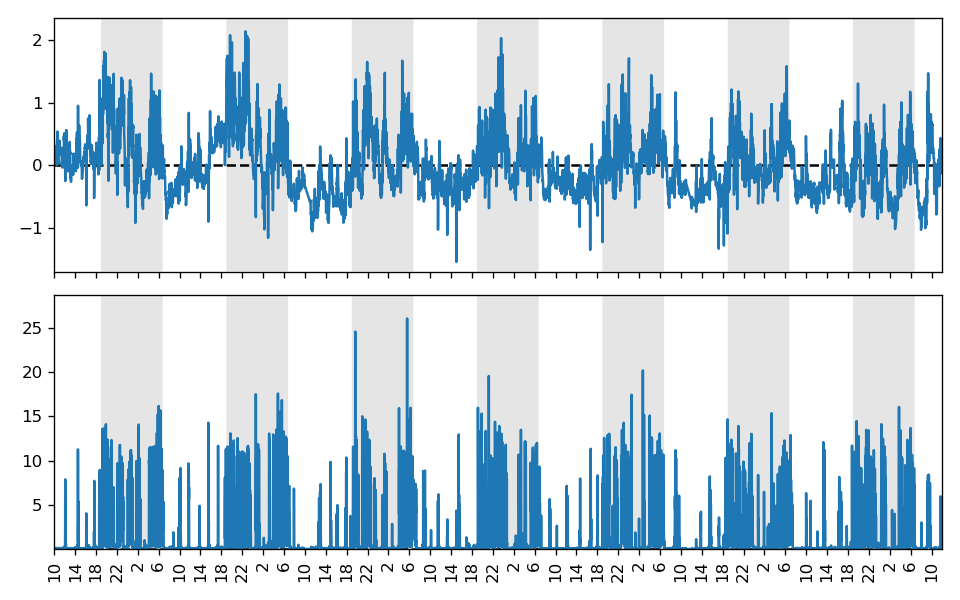

In [6]:


fig,ax = plt.subplots(2,1,figsize=(8,5),sharex=True )
plot_raw(data=data_min, y='temp_rt_corrected',ax=ax[0])
ax[0].grid(False)
ax[0].set_xticks(ticks=np.array(range(0,data_min.index[-1], 240)), labels=data_min.loc[range(0,data_min.index[-1], 240),'hour'], rotation=90 )
plot_raw(data=data_min, y='distance',ax=ax[1]) 
ax[1].set_xticks(np.array(range(0,data_min.index[-1], 240)), data_min.loc[range(0,data_min.index[-1], 240),'hour'], rotation=90  )
ax[1].grid(False)
plt.tight_layout()  





<IPython.core.display.Javascript object>


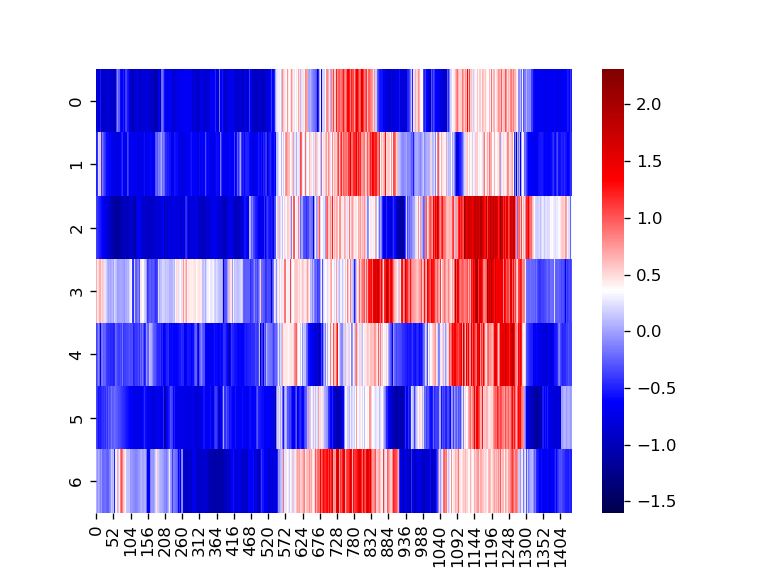

In [7]:
import seaborn as sns

temperature_each_day = dict()
for d,day in sub.iter_single_days(10):
    temperature_each_day[d] = day['temp_rt_corrected'].reset_index(drop=True)
temperature_each_day = pd.DataFrame.from_dict(temperature_each_day)
    
fig,ax = plt.subplots()
#ax.axhline(0,color='k',linestyle='--')
sns.heatmap( temperature_each_day.T, cmap='seismic')#, vmin=-1.5, vmax=1.5) #, color='b', alpha=.2)
#ax.plot( temperature_each_day.mean(axis=1), color='b', alpha=1 )
plt.show()


## Average 24h activity

In [8]:

# motion & temperature
isDay = list()
temperature = dict()
motion = dict()
for info,rec in tqdm( sub.iter_day_avg() , total=len(sub) ):
    rec = rec.sort_values(by='minute').reset_index(drop=True)
    motion[(info['geno'], info['id'])] = rec['distance']
    temperature[(info['geno'], info['id'])] = rec['temp_rt_corrected']
    isDay.append(rec['isDay'])
    
isDay = pd.concat(isDay,axis=1).mean(axis=1)
motion = pd.DataFrame.from_dict(motion)
temperature = pd.DataFrame.from_dict(temperature,)
#time_range = pd.timedelta_range(start='0 days 10:00:00', end='1 days 09:59:00', freq='1min')





100%|██████████| 16/16 [00:00<00:00, 64.98it/s]


<IPython.core.display.Javascript object>


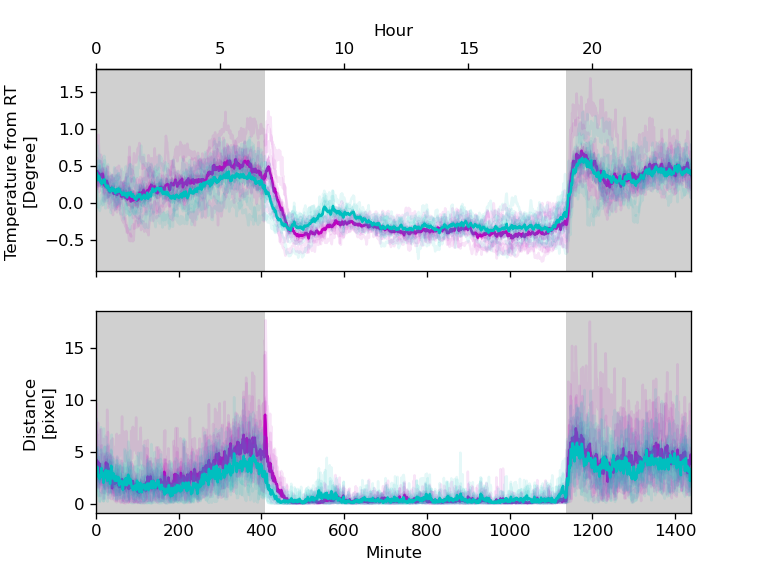

Text(0.5, 0, 'Minute')

In [9]:
fig,ax = plt.subplots(2,1,sharex=True) 
plot_avg( temperature.xs('KO',level=0,axis=1), isDay,color='m',ax=ax[0])
plot_avg( temperature.xs('WT',level=0,axis=1), isDay,color='c',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')
ax2 = ax[0].secondary_xaxis("top", functions=(lambda x: x/60, lambda x: x*60))
ax2.set_xlabel('Hour')

plot_avg( motion.xs('KO',level=0,axis=1), isDay,color='m', ax=ax[1])
plot_avg( motion.xs('WT',level=0,axis=1), isDay,color='c', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')
ax[1].set_xlabel('Minute')

In [3]:
isDay = list()
temperature = dict()
motion = dict()
for info,rec in tqdm( sub.iter_data() , total=len(sub) ):
    #rec = rec.sort_values(by='minute').reset_index(drop=True)
    motion[(info['geno'], info['id'])] = rec['distance']
    temperature[(info['geno'], info['id'])] = rec['temp_rt_diff']
    isDay.append(rec['isDay'])

isDay = pd.concat(isDay,axis=1).mean(axis=1)
motion = pd.DataFrame.from_dict(motion)
temperature = pd.DataFrame.from_dict(temperature,)

100%|██████████| 16/16 [00:00<00:00, 44.20it/s]


<IPython.core.display.Javascript object>


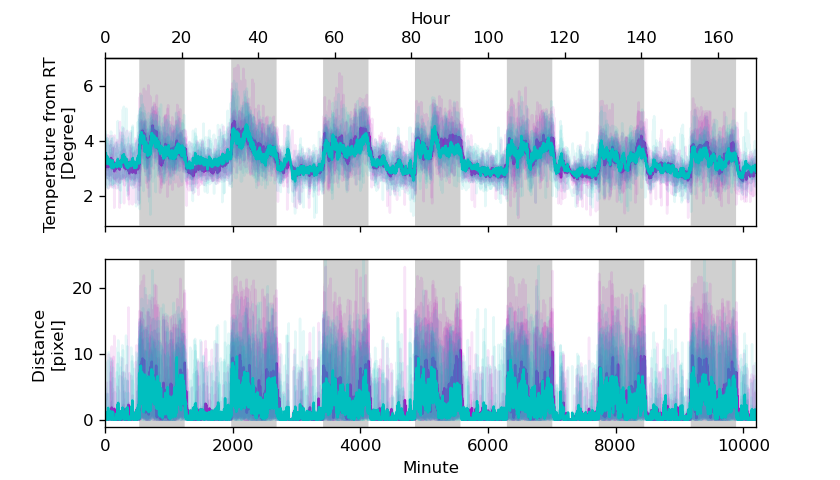

Text(0.5, 0, 'Minute')

In [4]:
fig,ax = plt.subplots(2,1,sharex=True, figsize=(7,4)) 
plot_avg( temperature.xs('KO',level=0,axis=1), isDay,color='m',ax=ax[0])
plot_avg( temperature.xs('WT',level=0,axis=1), isDay,color='c',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')
ax2 = ax[0].secondary_xaxis("top", functions=(lambda x: x/60, lambda x: x*60))
ax2.set_xlabel('Hour')

plot_avg( motion.xs('KO',level=0,axis=1), isDay,color='m', ax=ax[1])
plot_avg( motion.xs('WT',level=0,axis=1), isDay,color='c', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')
ax[1].set_xlabel('Minute')

In [32]:

from scipy.stats import ttest_1samp

class CrossCorrelation:
    # TODO add resamplig significance testing?
    def __init__(self, signal1, signal2, max_latency, resample=100):
        # signal1
        # signal2
        # max_latency [in minutes]
        # fs = frequency sampling [default: 60]
        # positive latency means that signal1 is lagging
        # negative latency means that signal1 is leading
        
        self.signal1 = signal1
        self.signal2 = signal2
        #self.cross_correlation = np.zeros(2 * max_latency + 1)
        #self.latencies = np.arange(-max_latency, max_latency + 1)
        
        #for index, latency in enumerate(self.latencies):
        #    shifted_signal = np.roll(self.signal2, latency)
        #    self.cross_correlation[index] = np.correlate(self.signal1, shifted_signal, mode='valid') / (np.linalg.norm(self.signal1) * np.linalg.norm(shifted_signal))
        
        self.cross_correlation, self.latencies = self.xcorr(self.signal1, self.signal2, max_latency)
        self.correlation_coeff = np.corrcoef(self.signal1, self.signal2)[0,1]
        
        if resample:
            per_xcrorr = np.zeros(( resample, len(self.cross_correlation) ) )
            for i in range(0,resample):
                per_sig = np.random.permutation(self.signal2)
                per_xcrorr[i], _ = self.xcorr( self.signal1, per_sig, max_latency)
        self.per_xcorr_avg = np.mean(per_xcrorr,axis=0)
                
        
        peak_pos = np.argmax(self.cross_correlation)
        peak_max = self.cross_correlation[peak_pos]
        peak_lat = self.latencies[peak_pos]
        if peak_lat>0:
            peak_sig1_is = 'lag'
        elif peak_lat<0:
            peak_sig1_is = 'lead'
        else:
            peak_sig1_is = 'equal'
            
        distr = per_xcrorr[:, peak_pos]
        t_statistic, p_val = ttest_1samp(distr,peak_max)
        self.summary = pd.DataFrame([[self.correlation_coeff,peak_pos,peak_max,peak_lat,peak_sig1_is,p_val]],columns=['corr_coeff','latency_sample','amplitude','latency_minute','signal_1_is','p-val'],index=[0])

    @staticmethod
    def xcorr(sig1,sig2,lat_max):
        cross_correlation = np.zeros(2 * lat_max + 1)
        latencies = np.arange(-lat_max, lat_max + 1)
        
        for index, latency in enumerate(latencies):
            shifted_signal = np.roll(sig2, latency)
            cross_correlation[index] = np.correlate(sig1, shifted_signal, mode='valid') / (np.linalg.norm(sig1) * np.linalg.norm(shifted_signal))
        
        return cross_correlation, latencies
    
    def plot(self):
        fig,ax = plt.subplots()
        ax.plot(cc.latencies ,cc.cross_correlation)
        ax.plot(cc.latencies ,cc.per_xcorr_avg)
        ax.axvline(0,color='k')
        ax.plot(cc.summary['latency_minute'],cc.summary['amplitude'],'sr')
        cc.summary
        
        
        

In [33]:
temperature

KO        WT        KO        WT                  KO        WT  \
          KO_69     WT_71     KO_70     WT_74     WT_79     KO_72     WT_81   
0      3.075742  3.557021  2.986998  3.268596  3.758822  3.661139  4.072969   
1      3.039879  3.819218  3.014151  3.276870  3.793956  3.766741  4.004045   
2      2.933127  3.827841  3.004214  3.314955  3.814753  3.802757  4.012131   
3      3.323815  3.845167  2.688735  3.363992  3.814305  3.781105  3.909382   
4      3.294091  3.718894  2.631760  3.430088  3.858407  3.786201  3.956127   
...         ...       ...       ...       ...       ...       ...       ...   
10196  2.980884  3.355189  2.804000  2.780097  3.539345  3.270073  3.053631   
10197  3.029604  3.072983  2.966343  2.809986  3.471215  3.292426  2.992013   
10198  2.895197  3.556437  2.940515  2.782133  3.474131  3.286702  3.010515   
10199  3.084438  3.500240  2.985660  2.695297  3.481091  3.192127  3.021733   
10200  2.884260  3.532022  3.104508  2.691408  3.422658  3.173845  2.851163   

             KO                  WT        KO        WT                  KO  \
          KO_75     KO_77     WT_83   KO_1021     WT_86     WT_91     KO_87   
0      3.237762  3.073002  3.371212  2.519167  3.288229  3.696209  3.038108   
1      3.229569  3.058205  3.151386  2.532867  3.261126  3.704289  3.059189   
2      3.236000  3.048893  3.092706  2.653970  2.924099  3.738027  3.058339   
3      3.353899  3.144601  3.031983  2.532336  2.828836  3.665661  3.065454   
4      3.482949  2.999830  2.996447  2.535262  2.866216  3.702073  3.049088   
...         ...       ...       ...       ...       ...       ...       ...   
10196  2.870473  2.951545  2.724795  3.130640  2.855573  2.800914  2.802669   
10197  2.911444  2.954887  2.699165  3.063143  2.856072  2.836206  2.776305   
10198  2.906919  2.971935  2.715765  3.132298  2.938021  2.848051  2.787772   
10199  2.880697  2.985875  2.648973  3.119217  2.987362  2.855709  2.797100   
10200  2.866155  3.002076  2.421290  3.100265  2.973119  2.799040  2.805172   

             WT        KO  
          WT_97     KO_99  
0      2.821120  3.914094  
1      2.841546  3.816394  
2      2.927371  3.820027  
3      2.986429  3.809996  
4      2.369457  3.792922  
...         ...       ...  
10196  2.522226  2.521410  
10197  2.560771  2.401474  
10198  2.320445  2.535587  
10199  2.450272  2.461331  
10200  2.346295  2.546539  

[10201 rows x 16 columns]

<IPython.core.display.Javascript object>


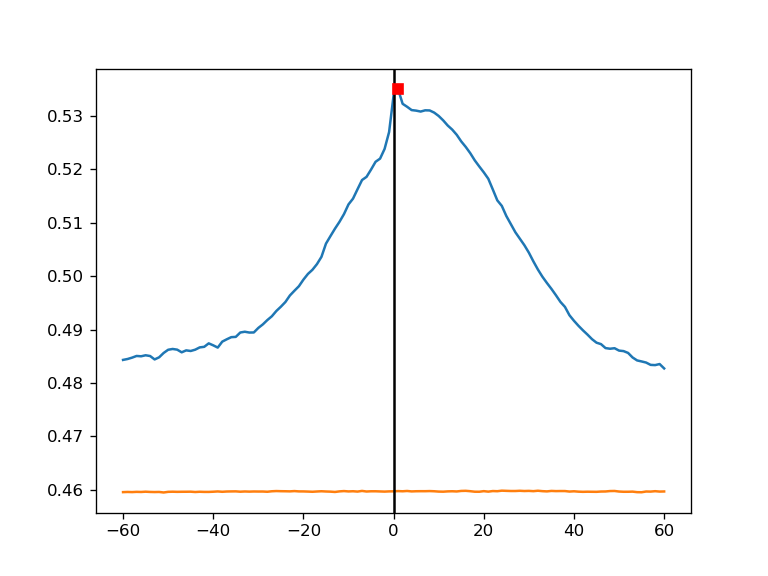

,corr_coeff,latency_sample,amplitude,latency_minute,signal_1_is,p-val
0,0.56951,61,0.534998,1,lag,1.883181e-179


In [34]:

chi = 'WT_74'
cc = CrossCorrelation(temperature[chi.split('_')[0]][chi], motion[chi.split('_')[0]][chi],60)
fig,ax = plt.subplots()
ax.plot(cc.latencies ,cc.cross_correlation)
ax.plot(cc.latencies ,cc.per_xcorr_avg)
ax.axvline(0,color='k')
ax.plot(cc.summary['latency_minute'],cc.summary['amplitude'],'sr')
cc.summary

In [97]:
cc,lat = cross_correlation(sig1, sig2, 50)

fig,ax = plt.subplots(2,1)
ax[0].plot(t,sig1,'r')
ax[0].plot(t,sig2,'g')
ax[1].plot(lat,cc,'r')
ax[1].axvline(0,color='k')

ValueError: too many values to unpack (expected 2)

<IPython.core.display.Javascript object>


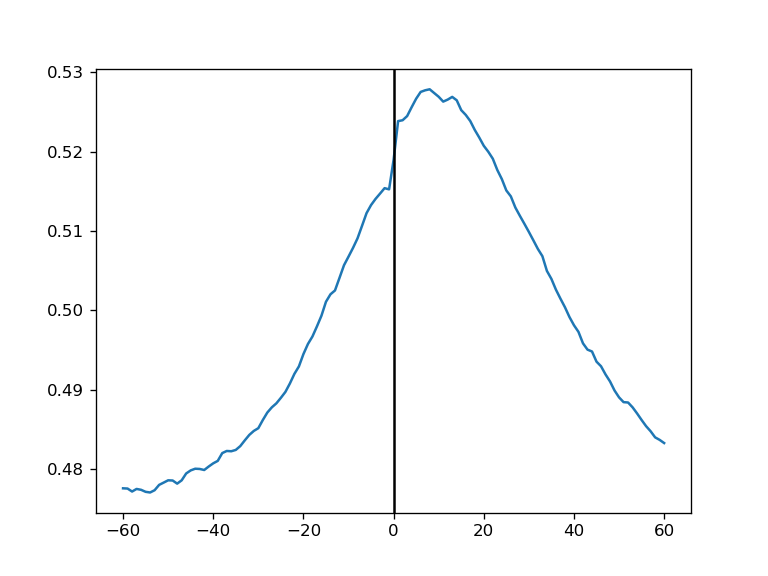

In [31]:
cc,lat = cross_correlation(temperature['WT']['WT_71'], motion['WT']['WT_71'],60)

fig,ax = plt.subplots()

ax.plot(lat,cc)
ax.axvline(0,color='k')

<IPython.core.display.Javascript object>


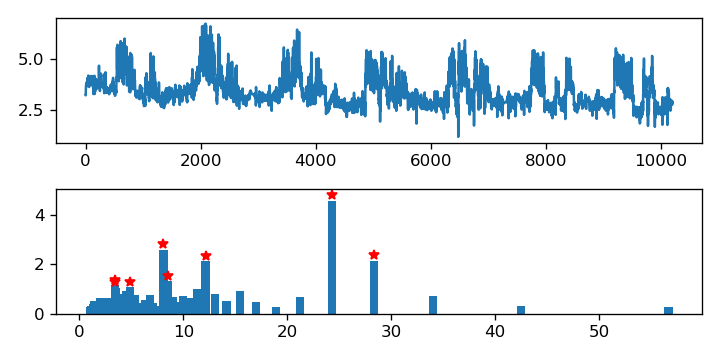

In [16]:
data_min = sub.get_data(7)
periodogram = Periodogram(data_min['temp_rt_diff'])
fig,ax = plt.subplots(2,1, figsize=(6,3))
ax[0].plot(data_min['temp_rt_diff'])
periodogram.plot(to_amp=True,ax=ax[1])

plt.tight_layout()


In [17]:

cos = Cosinor(data_min['distance'], 10+ (data_min.index/60),fs=60)
cos.components

,mesor,amplitude,period,acrophase
0,2.638575,2.80397,23.898047,23.094


<IPython.core.display.Javascript object>


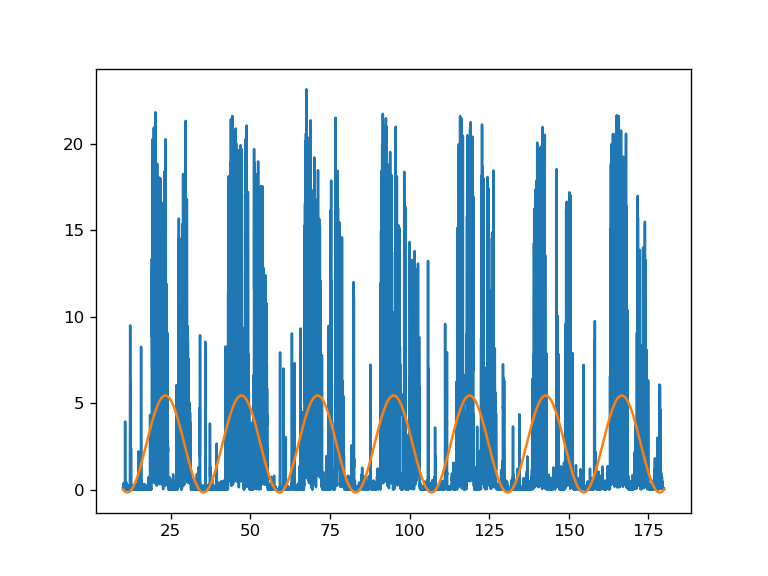

In [18]:

fig,ax = plt.subplots()
ax.plot(10+(data_min.index/60), data_min['distance'])
ax.plot(cos.time, cos.curve)

